# Tutorial: ORC-Nextrout

This is a tutorial on how to use the _**ORC-Nextrout**_ algorithm to solve  community detection problems.

## Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import sys
import os
from tqdm import tqdm
import requests
import json

import main

/home/dtheuerkauf/dmk/dmk_solver/globals/python_timedata
/home/dtheuerkauf/ORC-Nextrout/code
/home/dtheuerkauf/dmk/dmk_solver/otp_solver/preprocess/assembly
/home/dtheuerkauf/dmk/dmk_solver/build/python/fortran_python_interface


## Loading graph

We start by loading the sample graph. We use the _Les Miserables_ network data stored in the following link.

In [3]:
url = "http://bost.ocks.org/mike/miserables/miserables.json"
lesmis = json.loads(requests.get(url).text)
G = nx.readwrite.json_graph.node_link_graph(lesmis, multigraph=False)

We relabel the nodes of the graph, and get the number of communities.

In [4]:
nodes = G.nodes()
mapping = {n:idx_+1 for idx_,n in enumerate(nodes)}
G = nx.relabel_nodes(G, mapping)
print(nx.info(G))

K = len(set(list(dict(G.nodes(data='group')).values())))
print('Number of communities:',K)
for node in G.nodes():G.nodes[node]['community'] = G.nodes[node]['group']

Name: 
Type: Graph
Number of nodes: 77
Number of edges: 254
Average degree:   6.5974
Number of communities: 11


## Visualizing network

In [6]:
import processing_syn_results as psr
import plotting_tools as plotting

In [6]:
graph_model = 'real_net_les-mis'

Assigning markers and colors for nodes.

In [7]:
comm_label=psr.get_label(graph_model)
communities = G.nodes(data=comm_label)
plotting.set_markers_gt(G, communities, gt=True)

NameError: name 'graph_model' is not defined

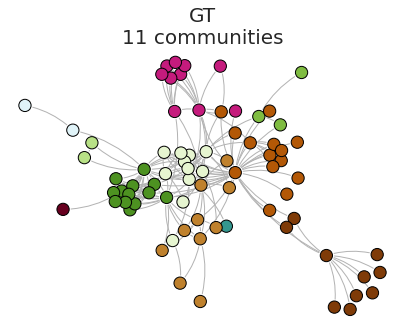

In [8]:
ns = 150
rseed = 10
fig, ax = plt.subplots(
        figsize=(7,5), nrows=1, ncols=1
    )
layout = nx.spring_layout(G, seed = rseed)

nodes = nx.draw_networkx_nodes(
    G,
    pos=layout,
    node_color=[G.nodes[node]["colour"] for node in G.nodes()],
    edgecolors="black",
    ax=ax,
    node_size=ns,
    # alpha=0.2,
)

for edge in G.edges():
    ax.annotate(
        "",
        xy=layout[edge[0]],
        xycoords="data",
        xytext=layout[edge[1]],
        textcoords="data",
        arrowprops=dict(
            arrowstyle="-",
            color="0.7",
            shrinkA=8,
            shrinkB=8,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0.15",
        ),
    )
ax.set_title(
                "GT" + "\n" + str(K) + " communities", fontsize=20,
            )
ax.axis("off")
nodes.set_zorder(10)

## ORC-Nextrout

Before solving the communtiy detection problem, we show how to use the main elements of the python ```ORC_Nextrout``` class. For that, we need to define the $\beta$ (```beta```) we would like to use:

In [9]:
beta = 2.0

Originally, the used graph has only the following attributes:

In [10]:
list(G.edges(data=True))[:5]

[(1, 2, {'value': 1}),
 (1, 3, {'value': 8}),
 (1, 4, {'value': 10}),
 (1, 5, {'value': 1}),
 (1, 6, {'value': 1})]

But once we run the ```compute_nextrout_ricci_flow``` functions:

In [11]:
# Reinitializing the class with the generated graph
orf = main.ORC_Nextrout(G)

# Defining beta (only makes a difference for 'Nextrout' method)
orf.beta_d = beta

# Do Ricci flow 'num_iter' times
orf.compute_nextrout_ricci_flow(iterations=1)

# Accesing the ORC attribute and making it initial condition
g = orf.G

the attributes of the graph get extended.

In [12]:
list(g.edges(data=True))[:5]

[(1,
  2,
  {'value': 1,
   'weight': 1.2441555866061678,
   'ricciCurvature': -0.17675184783439746,
   'original_RC': -2.0421578055040968e-05}),
 (1,
  3,
  {'value': 8,
   'weight': 1.4515784089488246,
   'ricciCurvature': -0.25621806698618466,
   'original_RC': -0.16674157806125445}),
 (1,
  4,
  {'value': 10,
   'weight': 1.4515784089488255,
   'ricciCurvature': -0.25621806698618355,
   'original_RC': -0.1667415780612551}),
 (1,
  5,
  {'value': 1,
   'weight': 1.2441555866061678,
   'ricciCurvature': -0.17675184783439768,
   'original_RC': -2.0421578055040968e-05}),
 (1,
  6,
  {'value': 1,
   'weight': 1.2441555866061684,
   'ricciCurvature': -0.17675184783439724,
   'original_RC': -2.0421578055485057e-05})]

The main quantity of interest for us is the ```weight```, since this is the quantity that tells us whether an edge should be removed.

### Community detection problem

We proceed to calculate the community partition given by our algorithm. It is computed used the function ```community_detection``` function. It outputs the graph ```g``` with modified weights, the ```community mapping``` dictionary (from nodes to commyunities), and the ```cutoff``` used to remove the edges.

In [14]:
met = 'Nextrout'
num_iter = 3

#### Running community detection #####

g,community_mapping, cutoff = main.community_detection(G, 
                                                   graph_model, 
                                                   met, 
                                                   num_iter, 
                                                   beta,
                                                   plotting = False, 
                                                 saving = True,
                                                   path2save = './../data/',
                                                    K=K,
                                                       )

iteration # 1 is stored at ./../data/communities_dict_Nextrout_beta=2.0_num_iter_1_real_net_les-mis.pkl
iteration # 2 is stored at ./../data/communities_dict_Nextrout_beta=2.0_num_iter_2_real_net_les-mis.pkl
iteration # 3 is stored at ./../data/communities_dict_Nextrout_beta=2.0_num_iter_3_real_net_les-mis.pkl


We show the distribution of nodes per communities:

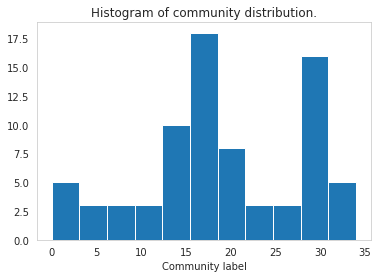

In [15]:
plt.hist(community_mapping.values(), bins = K)
plt.xlabel('Community label')

plt.title("Histogram of community distribution.")
plt.grid(False)

## Plotting results

We show the inferred communities together with the ground truth information.

In [16]:
outputs = {'Nextrout':[g,community_mapping,None]}

ground_truth
Nextrout


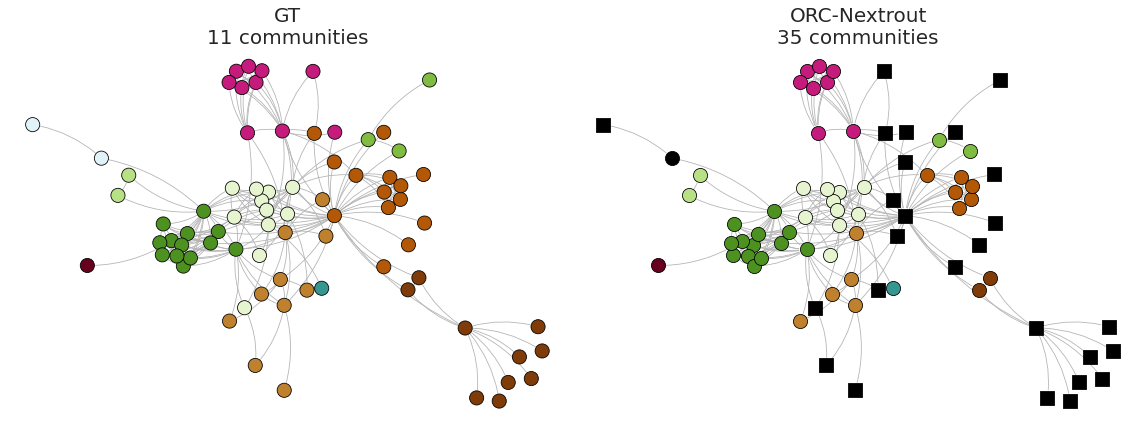

In [18]:
metric = 'ARI'
plotting.plot_no_markers(G, # ground truth network
                         communities, # ground truth communities
                         outputs, # output information
                         dataset=graph_model,
                        method_list=['ground_truth']+list(outputs.keys()), 
                  metric = metric, # accuracy score
                seed=rseed, # spring layout seed
                  comm_label=comm_label, # community attribute
                         wt = 2,# edge width
                         alpha = 0.2, 
                         ns = 200 #node size
                        )

# SBM

Let's take a look now at another example on SBM networks.

### Functions to plot SBM's
Let's first define a few functions to plot networks in a clean way.

In [110]:
def random_inner_circle_loc(circle_r,circle_x,circle_y):
    #https://stackoverflow.com/questions/30564015/how-to-generate-random-points-in-a-circular-distribution
    import random
    import math

    # random angle
    alpha = 2 * math.pi * random.random()
    # random radius
    r = circle_r * math.sqrt(random.random())
    # calculating coordinates
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y

    return x,y

In [111]:
def node_loc(g,
             centers, 
             community_list,
            comm_label = 'block'):
    
    for node in g.nodes():
        comm = g.nodes[node][comm_label]
        g.nodes[node]['pos'] = random_inner_circle_loc(0.5, centers[comm][0],centers[comm][1])
    

In [112]:
def plot_gt_comm(g):
    ns = 150
    rseed = 10
    fig, ax = plt.subplots(
            figsize=(7,5), nrows=1, ncols=1
        )
    layout = nx.get_node_attributes(g,'pos')
    #layout = community_layout(g, communities, seed = 15)

    nodes = nx.draw_networkx_nodes(
        g,
        pos=layout,
        node_color=[g.nodes[node]["colour"] for node in g.nodes()],
        edgecolors="black",
        ax=ax,
        node_size=ns,
        # alpha=0.2,
    )
    '''
    for edge in g.edges():
        ax.annotate(
            "",
            xy=layout[edge[0]],
            xycoords="data",
            xytext=layout[edge[1]],
            textcoords="data",
            arrowprops=dict(
                arrowstyle="-",
                color="0.7",
                shrinkA=8,
                shrinkB=8,
                patchA=None,
                patchB=None,
                connectionstyle="arc3,rad=0.15",
            ),
        )
    '''
    nx.draw_networkx_edges(
        g,
        layout,
        edge_color = 'gray',
        ax=ax,
        alpha=0.1,
    )

    ax.set_title(
                    "GT" + "\n" + str(K) + " communities", fontsize=20,
                )
    ax.axis("off")
    nodes.set_zorder(10)
    plt.show()

We choose now the probabilities of having intra- and intercommunity edges (p and q).

In [113]:
p = 0.5
q = 0.01

To generate the network, we use the nx function:

In [114]:
sizes = [20, 20, 20]
probs = [[p, q, q], [q, p, q], [q, q, p]]
g = nx.stochastic_block_model(sizes, probs, seed=0)
K = len(set(list(dict(g.nodes(data='block')).values())))
print(nx.info(g))

Name: stochastic_block_model
Type: Graph
Number of nodes: 60
Number of edges: 303
Average degree:  10.1000


In [115]:
comm_label='block'
communities = g.nodes(data=comm_label)
communities = dict(communities)
plotting.set_markers_gt(g, communities, gt=True)

In [116]:
centers = [(0,0),(1,1),(2,0)]
community_list = [0,1,2]
node_loc(g,
         centers,
        community_list)

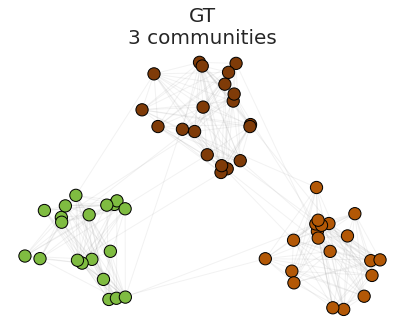

In [117]:
plot_gt_comm(g)

Let's get now the intra and intercommunity edges:

In [118]:
intracommunity_edges = [e for e in g.edges() if e[0] in range(20) and e[1] in range(20)]
intercommunity_edges = [e for e in g.edges() if e[0] in range(20) and e[1] in range(20,40)]

In [119]:
intracommunity_edges, intercommunity_edges

([(0, 3),
  (0, 4),
  (0, 6),
  (0, 8),
  (0, 9),
  (0, 13),
  (0, 16),
  (1, 3),
  (1, 7),
  (1, 8),
  (1, 9),
  (1, 13),
  (1, 15),
  (1, 18),
  (2, 3),
  (2, 6),
  (2, 7),
  (2, 9),
  (2, 10),
  (2, 12),
  (2, 14),
  (2, 17),
  (2, 18),
  (2, 19),
  (3, 6),
  (3, 15),
  (3, 17),
  (3, 19),
  (4, 5),
  (4, 6),
  (4, 9),
  (4, 10),
  (4, 18),
  (5, 6),
  (5, 13),
  (5, 18),
  (6, 7),
  (6, 10),
  (6, 12),
  (6, 13),
  (6, 15),
  (6, 17),
  (6, 18),
  (7, 8),
  (7, 13),
  (7, 17),
  (7, 18),
  (8, 9),
  (8, 10),
  (8, 12),
  (8, 13),
  (8, 14),
  (8, 17),
  (8, 18),
  (8, 19),
  (9, 10),
  (9, 11),
  (9, 13),
  (9, 14),
  (9, 16),
  (9, 17),
  (9, 19),
  (10, 11),
  (10, 15),
  (10, 18),
  (11, 13),
  (11, 14),
  (11, 16),
  (11, 17),
  (11, 18),
  (11, 19),
  (12, 15),
  (12, 16),
  (12, 18),
  (13, 14),
  (13, 16),
  (13, 17),
  (13, 18),
  (13, 19),
  (14, 16),
  (14, 17),
  (14, 18),
  (15, 19),
  (16, 17),
  (16, 19),
  (17, 18),
  (17, 19),
  (18, 19)],
 [(4, 28), (5, 22), (8, 39

Now we are ready to run the algorithm! This time we'll take a look at the evolution of the weights for some of the inter/intra community edges:

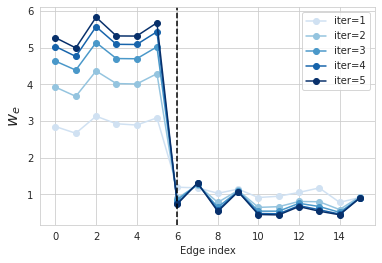

In [120]:
import importlib

#plt.axhline(y=0, color='k', linestyle='--')

num_iter = 5
met = "Nextrout"
beta = 1
colors = plt.cm.Blues(np.linspace(0,1,num_iter+1))

for itnum in range(1, num_iter + 1):

    # Cleaning the class info
    importlib.reload(main)

    # Reinitializing the class with the generated graph
    orf = main.ORC_Nextrout(g)

    # We define the method (by default, SinkhornMix)
    orf.method = met

    # Defining beta (only makes a difference for 'Nextrout' method)
    orf.beta_d = beta

    # Do Ricci flow 'num_iter' times
    orf.compute_nextrout_ricci_flow(iterations=1)

    # Accesing the ORC attribute and making it initial condition
    g = orf.G
    
    weights_inter = [tuple_[2] for tuple_ in list(g.edges(data='weight')) if (tuple_[0],tuple_[1]) in intercommunity_edges]
    weights_intra = [tuple_[2] for tuple_ in list(g.edges(data='weight')) if (tuple_[0],tuple_[1]) in intracommunity_edges]
       
    plt.plot(weights_inter[:10]+weights_intra[:10],'o-', color = colors[itnum], label = 'iter='+str(itnum))
    
plt.axvline(x = len(weights_inter[:10]), color='k', linestyle='--')
plt.xlabel('Edge index')
plt.ylabel(r'$w_e$', fontsize = 16)
plt.legend()
plt.show()

Intercommunity edges (to the left of the dotted line) get longer while intracommunity ones get shorter, as expected! Removing those longer ones will give us the desired communities.